In [10]:
!pip install composition_stats

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for composition_stats: filename=composition_stats-2.0.0-py3-none-any.whl size=15087 sha256=8e469febf1847169f68980a9a6575e4fafb45872a9bf09ca76ab22f2d2932d51
  Stored in directory: c:\users\emile\appdata\local\pip\cache\wheels\ec\23\d6\bb4debfbe0baf1ca43798dde906401f5b6760b177234817e4f
Successfully built composition_stats



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import composition_stats as cs
import os
# Set random seed for reproducibility
np.random.seed(42)


In [6]:
os.getcwd()

'c:\\Users\\Emile\\Documents\\Polytechnique\\4A\\ParisSaclay\\Stage\\spinal_cross_species_V1\\python_data_analysis'

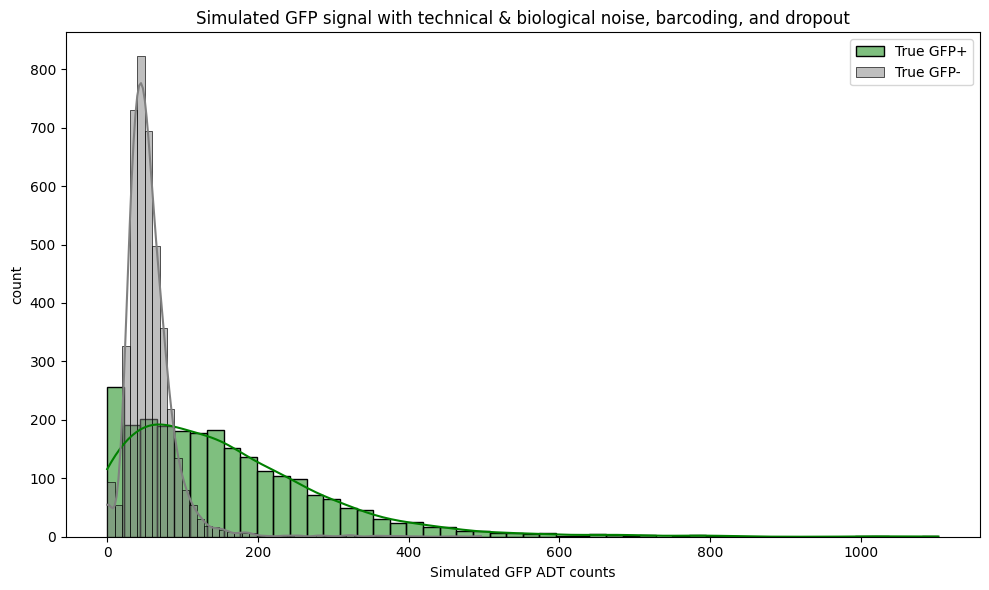

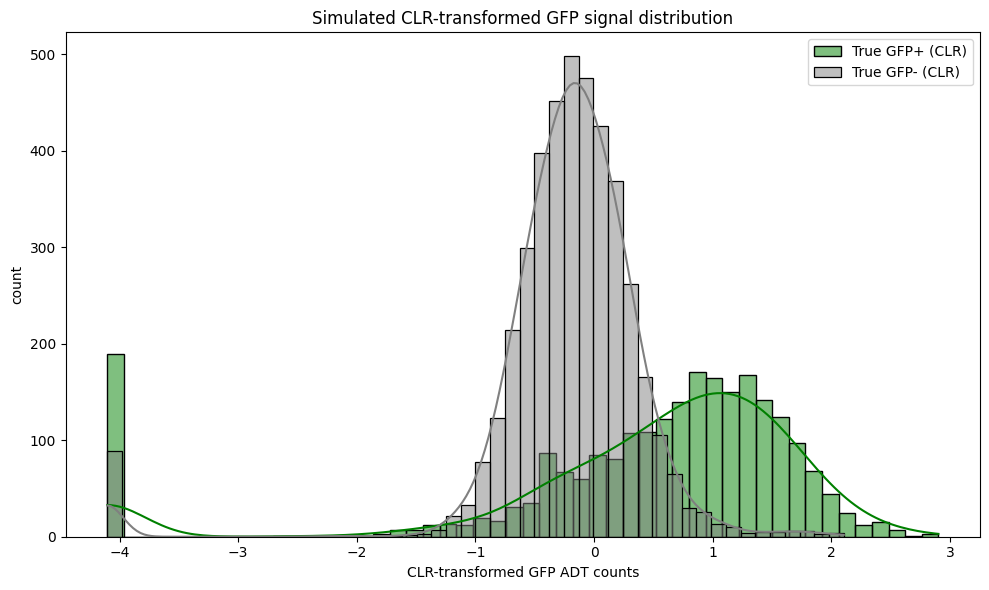

In [21]:
# Parameters
n_cells = 6600
prop_gfp_pos_pool = 1 / 3  # Estimated proportion of GFP+ in final pool

# Simulate true GFP status after pooling
Z = np.random.binomial(1, prop_gfp_pos_pool, n_cells)

# Expression parameters
mu_gfp_pos = 150
sigma_gfp_pos = 100
mu_gfp_neg = 50
sigma_gfp_neg = 2

# Simulate base expression
Y_clean = np.where(
    Z == 1,
    np.random.normal(mu_gfp_pos, sigma_gfp_pos, n_cells),
    np.random.normal(mu_gfp_neg, sigma_gfp_neg, n_cells)
)
Y_clean = np.clip(Y_clean, 0, None)

# Technical noise (RT-PCR, antibody): multiplicative log-normal
tech_noise = np.random.lognormal(mean=0, sigma=0.3, size=n_cells)
Y_noisy = Y_clean * tech_noise

# Stochastic barcoding/capture noise
barcoding_noise = np.random.lognormal(mean=0, sigma=0.3, size=n_cells)
Y_captured = Y_noisy * barcoding_noise

# Drop-out effect: higher dropout for lower counts
lambda_dropout = 10  # controls steepness of dropout curve
dropout_prob = np.exp(-Y_captured / lambda_dropout)
dropouts = np.random.rand(n_cells) < dropout_prob
Y_final = Y_captured.copy()
Y_final[dropouts] = 0

# Z = Z[Y_final < 2500]
# Y_final = Y_final[Y_final<2500]

# FACS error: flip 5% of labels
flip_mask = np.random.rand(len(Y_final)) < 0.05
Z_flipped = np.where(flip_mask, 1 - Z, Z)


# CLR transformation
Y_clr = np.log1p(Y_final) - np.mean(np.log1p(Y_final))

# Plot the result: original scale
fig = plt.figure(figsize=(10, 6))
sns.histplot(Y_final[Z_flipped == 1], bins=50, color='green', label='True GFP+', kde=True, stat="count")
sns.histplot(Y_final[Z_flipped == 0], bins=50, color='gray', label='True GFP-', kde=True, stat="count")
plt.xlabel("Simulated GFP ADT counts")
plt.ylabel("count")
plt.title("Simulated GFP signal with technical & biological noise, barcoding, and dropout")
plt.legend()
plt.tight_layout()
fig.savefig('figures/human_simulated_adt_counts.svg')
plt.show()

# Plot the CLR-transformed values
fig = plt.figure(figsize=(10, 6))
sns.histplot(Y_clr[Z_flipped == 1], bins=50, color='green', label='True GFP+ (CLR)', kde=True, stat="count")
sns.histplot(Y_clr[Z_flipped == 0], bins=50, color='gray', label='True GFP- (CLR)', kde=True, stat="count")
plt.xlabel("CLR-transformed GFP ADT counts")
plt.ylabel("count")
plt.title("Simulated CLR-transformed GFP signal distribution")
plt.legend()
plt.tight_layout()
fig.savefig('figures/human_simulated_adt_counts_clr.svg')
plt.show()



In [5]:
len(Y_clr)

6600

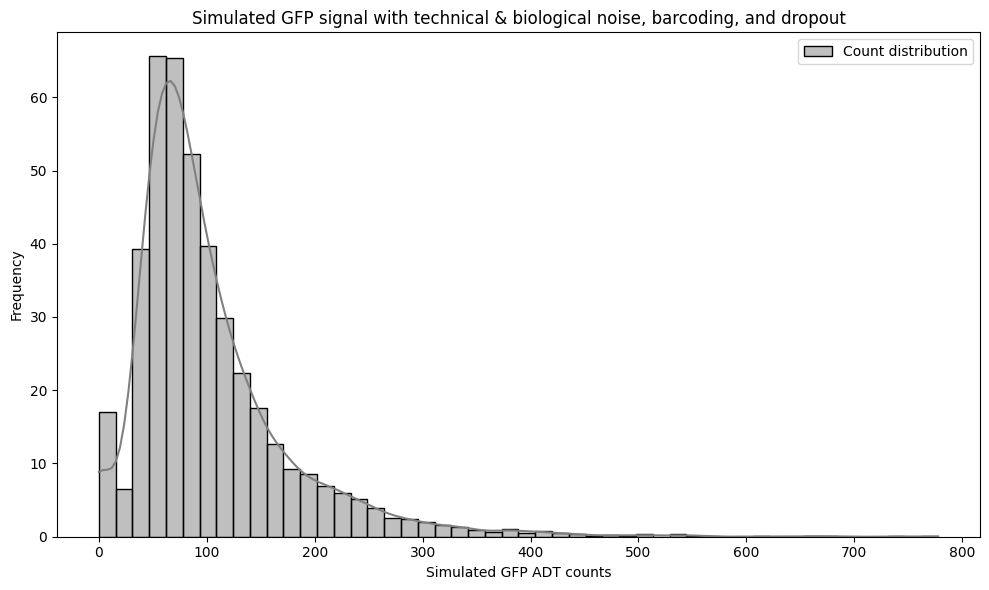

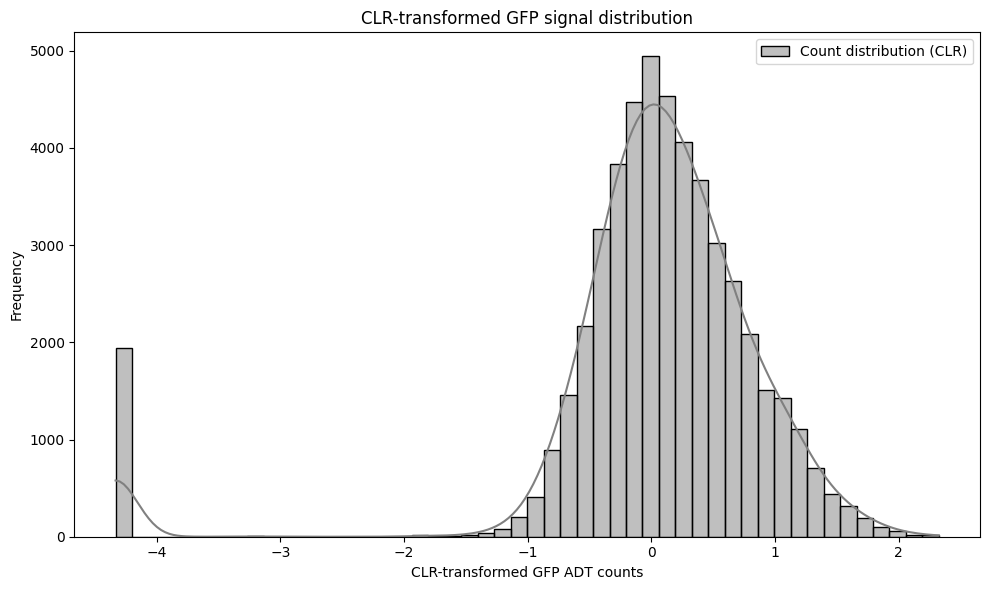

In [3]:
# Plot the total distribution
plt.figure(figsize=(10, 6))
sns.histplot(Y_final, bins=50, color='gray', label='Count distribution', kde=True, stat="frequency")
plt.xlabel("Simulated GFP ADT counts")
plt.ylabel("Frequency")
plt.title("Simulated GFP signal with technical & biological noise, barcoding, and dropout")
plt.legend()
plt.tight_layout()
plt.show()


# Plot the CLR-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(Y_clr, bins=50, color='gray', label='Count distribution (CLR)', kde=True, stat="frequency")
plt.xlabel("CLR-transformed GFP ADT counts")
plt.ylabel("Frequency")
plt.title("CLR-transformed GFP signal distribution")
plt.legend()
plt.tight_layout()
plt.show()
